## **ANALYSE D'ÉCARTS ENTRE NOMBRES PREMIERS CONSÉCUTIFS**

#### **1. Création d'une classe `PrimeGapAnalyzer` qui a comme méthodes les différents outils de l'analyse**

- **`__init__(self, max_n: int = 10**7)`**  
  Initialise l’analyseur avec une borne supérieure `max_n` et prépare les structures de données pour les nombres premiers, les écarts et les ratios.

- **`sieve_of_eratosthenes_basic(n: int)`**  
  Implémente un crible d'Ératosthène simple pour calculer tous les nombres premiers ≤ `n`.

- **`segmented_sieve_segment(start, end, base_primes)`**  
  Effectue un crible segmenté dans l’intervalle `[start, end)` en utilisant les nombres premiers de base pour trouver les premiers dans un segment.

- **`segmented_sieve(n)`**  
  Génère tous les nombres premiers jusqu’à `n` à l’aide d’un crible segmenté en mémoire adaptative.

- **`compute_gaps_and_ratios()`**  
  Calcule les écarts entre nombres premiers successifs et les ratios \( g_k / \log(p_k) \).

- **`generate_primes(save_cache=True)`**  
  Génère les nombres premiers jusqu’à `max_n` avec possibilité d’utiliser ou de créer un cache local.

- **`analyze_distribution()`**  
  Produit des statistiques descriptives (moyenne, médiane, écart-type, etc.) sur les ratios \( g_k / \log(p_k) \).

- **`plot_histogram(bins=100, save_fig=True)`**  
  Affiche plusieurs visualisations des écarts et des ratios : histogrammes, courbes de convergence et Q-Q plot.

- **`convergence_analysis(n_points=20)`**  
  Analyse la convergence du ratio moyen \( g_k / \log(p_k) \) vers 1 en fonction de la taille des premiers considérés.

- **`export_data()`**  
  Exporte toutes les données (nombres premiers, écarts, ratios, stats) au format `.pkl` et `.csv` pour une analyse ultérieure.

- **`run_full_analysis()`**  
  Lance toute la chaîne de traitement : génération, calculs, statistiques, visualisations, analyse de convergence et exportation des données.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
from numba import jit
import time
import pickle
import os

class PrimeGapAnalyzer:
    def __init__(self, max_n: int = 10**7):
        self.max_n = max_n
        self.primes = []
        self.gaps = []
        self.ratios = []
        
    @staticmethod
    @jit(nopython=True)
    def sieve_of_eratosthenes_basic(n: int) -> np.ndarray:
        """Crible d'Ératosthène basique pour les petits nombres premiers"""
        is_prime = np.ones(n + 1, dtype=np.bool_)
        is_prime[0] = is_prime[1] = False
        
        for i in range(2, int(np.sqrt(n)) + 1):
            if is_prime[i]:
                for j in range(i * i, n + 1, i):
                    is_prime[j] = False
        
        return np.where(is_prime)[0]
    
    @staticmethod
    @jit(nopython=True)
    def segmented_sieve_segment(start: int, end: int, base_primes: np.ndarray) -> np.ndarray:
        """Crible un segment [start, end) avec les nombres premiers de base"""
        size = end - start
        is_prime = np.ones(size, dtype=np.bool_)
        
        for p in base_primes:
            if p * p > end:
                break
                
            # Trouver le premier multiple de p dans [start, end)
            first_multiple = ((start + p - 1) // p) * p
            if first_multiple == p:  # p lui-même
                first_multiple = p * p
                
            # Marquer tous les multiples de p dans le segment
            for j in range(max(first_multiple, p * p), end, p):
                if j >= start:
                    is_prime[j - start] = False
        
        # Retourner les indices des nombres premiers dans le segment
        return np.where(is_prime)[0] + start
    
    def segmented_sieve(self, n: int) -> np.ndarray:
        """
        Crible segmenté optimisé pour générer tous les premiers ≤ n
        Divise le problème en segments pour une meilleure gestion mémoire
        """
        print(f"Génération des nombres premiers jusqu'à {n:,}")
        
        # Étape 1: Générer les nombres premiers de base jusqu'à √n
        sqrt_n = int(np.sqrt(n)) + 1
        base_primes = self.sieve_of_eratosthenes_basic(sqrt_n)
        print(f"Nombres premiers de base générés: {len(base_primes)} (jusqu'à {sqrt_n})")
        
        # Étape 2: Crible segmenté pour le reste
        segment_size = max(32768, sqrt_n)  # Taille de segment adaptative
        all_primes = [base_primes]
        
        current = sqrt_n + 1
        while current <= n:
            end = min(current + segment_size, n + 1)
            segment_primes = self.segmented_sieve_segment(current, end, base_primes)
            
            if len(segment_primes) > 0:
                all_primes.append(segment_primes)
            
            current = end
            if current % (10 * segment_size) == 1:  # Progress update
                print(f"Progression: {current:,} / {n:,} ({100 * current / n:.1f}%)")
        
        # Combiner tous les segments
        result = np.concatenate(all_primes)
        print(f"Nombres premiers générés: {len(result):,}")
        return result
    
    def compute_gaps_and_ratios(self) -> None:
        """Calcule les écarts g_k et les ratios g_k / log(p_k)"""
        print("Calcul des écarts et ratios...")
        
        n_primes = len(self.primes)
        self.gaps = np.zeros(n_primes - 1)
        self.ratios = np.zeros(n_primes - 1)
        
        for i in range(n_primes - 1):
            self.gaps[i] = self.primes[i + 1] - self.primes[i]
            self.ratios[i] = self.gaps[i] / np.log(self.primes[i])
        
        print(f"Écarts calculés: {len(self.gaps):,}")
        print(f"Ratio moyen g_k / log(p_k): {np.mean(self.ratios):.4f}")
        print(f"Écart-type des ratios: {np.std(self.ratios):.4f}")
    
    def generate_primes(self, save_cache: bool = True) -> None:
        """Génère les nombres premiers avec mise en cache"""
        cache_file = f"primes_{self.max_n}.pkl"
        
        if os.path.exists(cache_file):
            print(f"Chargement du cache: {cache_file}")
            with open(cache_file, 'rb') as f:
                self.primes = pickle.load(f)
        else:
            start_time = time.time()
            self.primes = self.segmented_sieve(self.max_n)
            duration = time.time() - start_time
            print(f"Génération terminée en {duration:.2f} secondes")
            
            if save_cache:
                print(f"Sauvegarde du cache: {cache_file}")
                with open(cache_file, 'wb') as f:
                    pickle.dump(self.primes, f)
    
    def analyze_distribution(self) -> dict:
        """Analyse statistique de la distribution des ratios"""
        print("\n=== ANALYSE STATISTIQUE ===")
        
        stats = {
            'mean': np.mean(self.ratios),
            'std': np.std(self.ratios),
            'median': np.median(self.ratios),
            'min': np.min(self.ratios),
            'max': np.max(self.ratios),
            'q25': np.percentile(self.ratios, 25),
            'q75': np.percentile(self.ratios, 75)
        }
        
        print(f"Moyenne: {stats['mean']:.4f}")
        print(f"Médiane: {stats['median']:.4f}")
        print(f"Écart-type: {stats['std']:.4f}")
        print(f"Min: {stats['min']:.4f}, Max: {stats['max']:.4f}")
        print(f"Q1: {stats['q25']:.4f}, Q3: {stats['q75']:.4f}")
        
        return stats
    
    def plot_histogram(self, bins: int = 100, save_fig: bool = True) -> None:
        """Trace l'histogramme des ratios g_k / log(p_k)"""
        plt.figure(figsize=(12, 8))
        
        # Histogramme principal
        plt.subplot(2, 2, 1)
        n, bins_edges, patches = plt.hist(self.ratios, bins=bins, density=True, 
                                         alpha=0.7, color='skyblue', edgecolor='black')
        plt.axvline(np.mean(self.ratios), color='red', linestyle='--', 
                   label=f'Moyenne: {np.mean(self.ratios):.3f}')
        plt.axvline(1.0, color='green', linestyle='-', 
                   label='Théorie: 1.0')
        plt.xlabel('g_k / log(p_k)')
        plt.ylabel('Densité')
        plt.title('Distribution des ratios g_k / log(p_k)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Évolution du ratio moyen
        plt.subplot(2, 2, 2)
        window_size = len(self.ratios) // 100
        if window_size > 1:
            moving_avg = np.convolve(self.ratios, np.ones(window_size)/window_size, mode='valid')
            x_vals = np.arange(window_size//2, len(self.ratios) - window_size//2)
            plt.plot(x_vals, moving_avg, 'b-', alpha=0.7)
            plt.axhline(1.0, color='green', linestyle='-', label='Théorie: 1.0')
            plt.xlabel('Indice k')
            plt.ylabel('Ratio moyen (fenêtre glissante)')
            plt.title('Convergence vers 1')
            plt.legend()
            plt.grid(True, alpha=0.3)
        
        # Distribution des écarts
        plt.subplot(2, 2, 3)
        plt.hist(self.gaps, bins=50, density=True, alpha=0.7, color='lightcoral')
        plt.xlabel('Écart g_k')
        plt.ylabel('Densité')
        plt.title('Distribution des écarts g_k')
        plt.grid(True, alpha=0.3)
        
        # Q-Q plot pour tester la distribution exponentielle
        plt.subplot(2, 2, 4)
        from scipy import stats
        # Normalisation pour la distribution exponentielle
        normalized_ratios = self.ratios / np.mean(self.ratios)
        stats.probplot(normalized_ratios, dist=stats.expon, plot=plt)
        plt.title('Q-Q plot vs distribution exponentielle')
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        
        if save_fig:
            plt.savefig(f'prime_gaps_analysis_{self.max_n}.png', dpi=300, bbox_inches='tight')
            print(f"Graphique sauvegardé: prime_gaps_analysis_{self.max_n}.png")
        
        plt.show()
    
    def convergence_analysis(self, n_points: int = 20) -> None:
        """Analyse de la convergence en fonction de la taille"""
        print("\n=== ANALYSE DE CONVERGENCE ===")
        
        step_size = len(self.primes) // n_points
        convergence_points = []
        
        for i in range(1, n_points + 1):
            end_idx = min(i * step_size, len(self.ratios))
            subset_ratios = self.ratios[:end_idx]
            mean_ratio = np.mean(subset_ratios)
            std_ratio = np.std(subset_ratios)
            
            convergence_points.append({
                'n_primes': end_idx + 1,
                'max_prime': self.primes[end_idx],
                'mean_ratio': mean_ratio,
                'std_ratio': std_ratio,
                'distance_to_1': abs(mean_ratio - 1.0)
            })
        
        # Graphique de convergence
        plt.figure(figsize=(10, 6))
        
        max_primes = [p['max_prime'] for p in convergence_points]
        mean_ratios = [p['mean_ratio'] for p in convergence_points]
        distances = [p['distance_to_1'] for p in convergence_points]
        
        plt.subplot(1, 2, 1)
        plt.semilogx(max_primes, mean_ratios, 'bo-', markersize=4)
        plt.axhline(1.0, color='green', linestyle='-', alpha=0.7)
        plt.xlabel('Plus grand nombre premier considéré')
        plt.ylabel('Ratio moyen g_k / log(p_k)')
        plt.title('Convergence vers 1')
        plt.grid(True, alpha=0.3)
        
        plt.subplot(1, 2, 2)
        plt.loglog(max_primes, distances, 'ro-', markersize=4)
        plt.xlabel('Plus grand nombre premier considéré')
        plt.ylabel('|Ratio moyen - 1|')
        plt.title('Distance à la conjecture')
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(f'convergence_analysis_{self.max_n}.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        return convergence_points
    
    def export_data(self) -> None:
        """Exporte les données pour analyse ultérieure"""
        data = {
            'max_n': self.max_n,
            'n_primes': len(self.primes),
            'primes': self.primes,
            'gaps': self.gaps,
            'ratios': self.ratios,
            'statistics': self.analyze_distribution()
        }
        
        filename = f'prime_gaps_data_{self.max_n}.pkl'
        with open(filename, 'wb') as f:
            pickle.dump(data, f)
        
        print(f"Données exportées: {filename}")
        
        # Export CSV pour analyse externe
        csv_data = np.column_stack((
            self.primes[:-1],  # p_k
            self.primes[1:],   # p_{k+1}
            self.gaps,         # g_k
            self.ratios        # g_k / log(p_k)
        ))
        
        csv_filename = f'prime_gaps_data_{self.max_n}.csv'
        np.savetxt(csv_filename, csv_data, 
                  header='p_k,p_k+1,gap,ratio', 
                  delimiter=',', fmt='%d,%d,%d,%.6f')
        print(f"Données CSV exportées: {csv_filename}")
    
    def run_full_analysis(self) -> None:
        """Lance l'analyse complète"""
        print(f"=== ANALYSE DES ÉCARTS ENTRE NOMBRES PREMIERS ===")
        print(f"Limite: {self.max_n:,}")
        
        # Génération des nombres premiers
        self.generate_primes()
        
        # Calcul des écarts et ratios
        self.compute_gaps_and_ratios()
        
        # Analyse statistique
        stats = self.analyze_distribution()
        
        # Visualisations
        self.plot_histogram()
        
        # Analyse de convergence
        convergence_data = self.convergence_analysis()
        
        # Export des données
        self.export_data()
        
        # Résumé final
        print(f"\n=== RÉSUMÉ FINAL ===")
        print(f"Nombres premiers générés: {len(self.primes):,}")
        print(f"Plus grand premier: {self.primes[-1]:,}")
        print(f"Ratio moyen g_k / log(p_k): {stats['mean']:.6f}")
        print(f"Distance à la conjecture: {abs(stats['mean'] - 1.0):.6f}")
        print(f"La conjecture g_k / log(p_k) ≈ 1 semble {'CONFIRMÉE' if abs(stats['mean'] - 1.0) < 0.05 else 'PARTIELLEMENT CONFIRMÉE'}")



### **2. Lancement du test avec les nombres premiers inférieurs à $10^7$**

=== ANALYSE DES ÉCARTS ENTRE NOMBRES PREMIERS ===
Limite: 10,000,000
Génération des nombres premiers jusqu'à 10,000,000
Nombres premiers de base générés: 447 (jusqu'à 3163)
Nombres premiers générés: 664,579
Génération terminée en 4.80 secondes
Sauvegarde du cache: primes_10000000.pkl
Calcul des écarts et ratios...
Écarts calculés: 664,578
Ratio moyen g_k / log(p_k): 1.0005
Écart-type des ratios: 0.8288

=== ANALYSE STATISTIQUE ===
Moyenne: 1.0005
Médiane: 0.7659
Écart-type: 0.8288
Min: 0.1241, Max: 10.1970
Q1: 0.3909, Q3: 1.3675
Graphique sauvegardé: prime_gaps_analysis_10000000.png


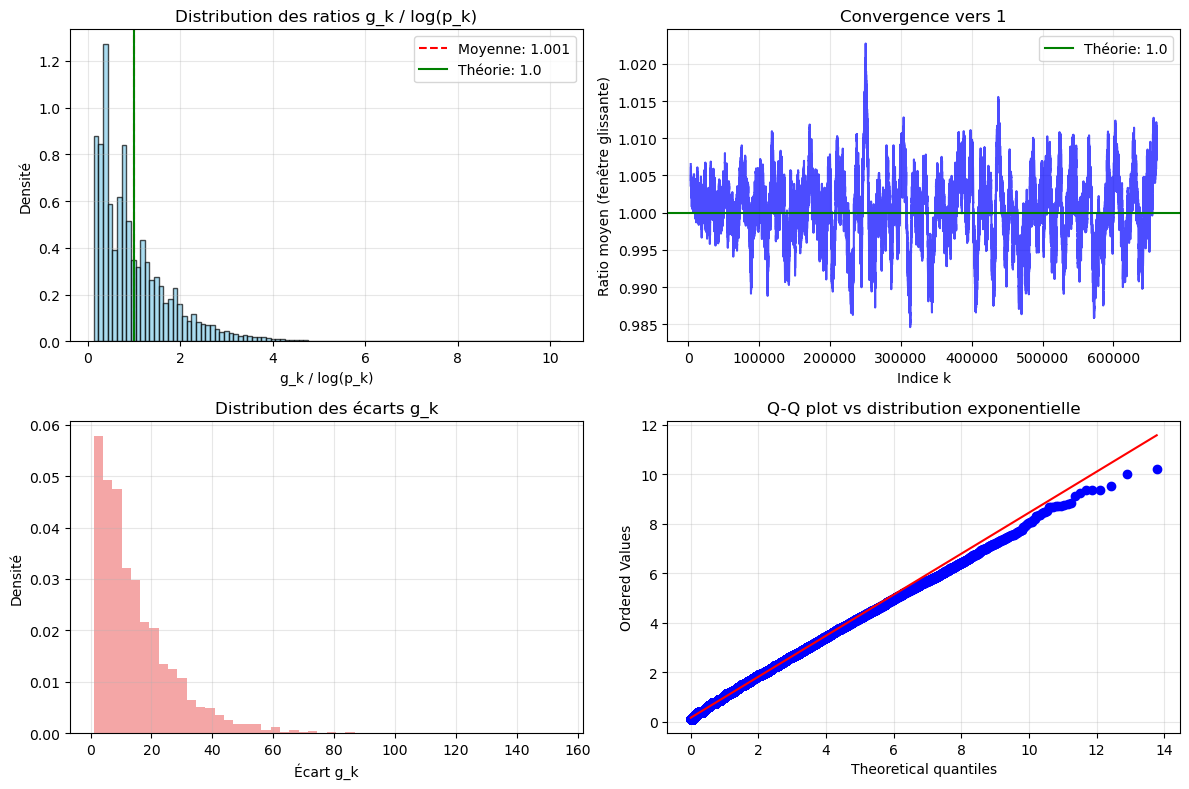


=== ANALYSE DE CONVERGENCE ===


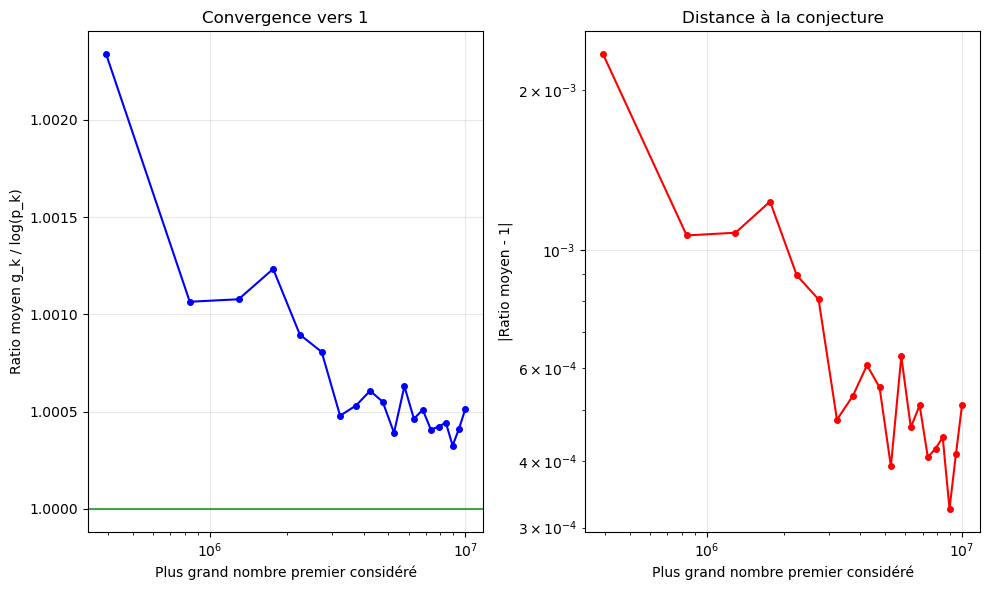


=== ANALYSE STATISTIQUE ===
Moyenne: 1.0005
Médiane: 0.7659
Écart-type: 0.8288
Min: 0.1241, Max: 10.1970
Q1: 0.3909, Q3: 1.3675
Données exportées: prime_gaps_data_10000000.pkl
Données CSV exportées: prime_gaps_data_10000000.csv

=== RÉSUMÉ FINAL ===
Nombres premiers générés: 664,579
Plus grand premier: 9,999,991
Ratio moyen g_k / log(p_k): 1.000513
Distance à la conjecture: 0.000513
La conjecture g_k / log(p_k) ≈ 1 semble CONFIRMÉE


In [3]:
analyzer_7 = PrimeGapAnalyzer(max_n=10**7)
analyzer_7.run_full_analysis()